<a href="https://colab.research.google.com/github/lak18/Mel-Spectrogram-generation/blob/main/Project_Code_S2T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jiwer

In [ ]:
!pip install jiwer  # Install jiwer

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display

from tensorflow import keras
from tensorflow.keras import layers
from  IPython import display
from jiwer import wer  # Now import jiwer after installation

from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input,
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

In [ ]:
import urllib.request
from tqdm import tqdm
import os
import tarfile

data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = os.path.join(os.getcwd(), "LJSpeech-1.1.tar.bz2")

# Function to download a file with progress bar
def download_url(url, dest):
    response = urllib.request.urlopen(url)
    total_size = int(response.getheader('Content-Length').strip())
    block_size = 1024
    with open(dest, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=dest, initial=0, ascii=True) as pbar:
            while True:
                buffer = response.read(block_size)
                if not buffer:
                    break
                f.write(buffer)
                pbar.update(len(buffer))

# Download the file
download_url(data_url, data_path)

# Extract the tar file
with tarfile.open(data_path, "r:bz2") as tar:
    tar.extractall(path=os.path.dirname(data_path))

wavs_path = os.path.join(os.path.dirname(data_path), "LJSpeech-1.1/wavs/")
metadata_path = os.path.join(os.path.dirname(data_path), "LJSpeech-1.1/metadata.csv")


/content/LJSpeech-1.1.tar.bz2: 100%|##########| 2.75G/2.75G [01:10<00:00, 38.9MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv( metadata_path, sep="|", header=None, quoting=3 )

In [ ]:
metadata_df.head(5)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
# Dropping transcription column

# Get the current column names
current_columns = metadata_df.columns

# Create a list of new column names, ensuring it has the same length as the current ones
new_columns = ["file_name", "normalized_transcription", "third_column_name"]  # Replace 'third_column_name' with the appropriate name

# Assign the new column names
metadata_df.columns = new_columns

metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)


metadata_df.head(4)

,file_name,normalized_transcription
0,LJ030-0012,"In Houston, as elsewhere during the trip, the ..."
1,LJ039-0209,They were instead firing to determine how rapi...
2,LJ032-0272,(3) fibers found on the rifle most probably ca...
3,LJ002-0330,female visitors carried them out of the prison...


In [ ]:
# We Now Split the data into Traning and Validation Set

split = int( len(metadata_df) * 0.90)
df_train = metadata_df[:split]          # Using 90% of data for training
df_val = metadata_df[split: ]           # Using 10% of data for testing and validation

print(f"Size of the Traning Set: {len(df_train)}")
print(f"Size of the Testing Set: {len(df_val)}" )

Size of the Traning Set: 11790
Size of the Testing Set: 1310


In [ ]:

# Define the set of accepted characters
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapping each character to an integer
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integer back to original characters
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

# Print the vocabulary and its size
print(f"The vocabulary is: {char_to_num.get_vocabulary()} (size = {char_to_num.vocabulary_size()})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size = 31)


In [ ]:
# Now we have to define

# Features
# An integer scaler tensor. The window length in samples
frame_length = 256

# An integer scaler tensor. The number of samples to step.
frame_step = 160

# An integer scaler tensor. The size of the FFT to apply.
# If Not provided, uses the samllest power of 2 enclosing frame_lenght()

fft_length = 384


def encode_single_sample( wav_file, label ):


  ###########################################################
  #### Process the Audio
  ###########################################################
  # 1. Read Wav file
  file = tf.io.read_file( wavs_path + wav_file + ".wav")
  # 2. Decode the wav file
  audio, _ = tf.audio.decode_wav( file )
  #audio = tf.squeeze(audio, axis=-1)         # try to remove repeated tensors from data
  # 3. Change type to float
  audio = tf.cast( audio, tf.float32 )        # change from audio to float32
  # 4. Get the spectrogram  --> stff = short time fourier transform
  # stff ---> one there is a Long signal and another is there short signal window
  # short singal filter is applied to long signal and convet into another long term signal
  spectrogram = tf.signal.stft(
      audio, frame_length = frame_length, frame_step= frame_step, fft_length=fft_length
  )


  # 5. We only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs( spectrogram )                 # finding absoulte values of result
  spectrogram = tf.math.pow( spectrogram, 0.3 )       # All Elements of spectrogram is divided by 2 or multiply by 0.5 ~ 1/2


  # 6. Normalization
  means = tf.math.reduce_mean( spectrogram , 1, keepdims= True)               # mean --> every element is divided my maximum value
  stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
  spectrogram = ( spectrogram - means ) / ( stddevs + 1e-10)                  # define our spectorgram

# spectorgram is our input ---> it is need to be convert in vectors




  #########################################
  ## Process the label
  #########################################

  # 7. Convert label to lower case
  label = tf.strings.lower( label )

  # 8. Split the label
  label = tf.strings.unicode_split( label, input_encoding="UTF-8")

  # 9. Map the characters in label to numbers
  label = char_to_num( label )

  # 10. Return a dict as our model is expecting tow inputs
  return spectrogram, label



In [ ]:


# we create a tf.data.Dataset object that yields the tranformed elements,
# in the same orders as they apperared in the input.

batch_size = 32



# Define the training dataset       ---> Peforming batching on training data
train_dataset = tf.data.Dataset.from_tensor_slices(
    ( list(df_train["file_name"]), list(df_train["normalized_transcription"]) )
)

train_dataset = (
    train_dataset.map( encode_single_sample , num_parallel_calls = tf.data.AUTOTUNE )
    .padded_batch( batch_size )                     # Combined spectorgram and preprocessed label are used as batch of size 32
    .prefetch( buffer_size = tf.data.AUTOTUNE )
)





# Define the validation dataset     ---> Peforming same batching on validation data
validation_dataset = tf.data.Dataset.from_tensor_slices(
    ( list(df_train["file_name"]), list(df_train["normalized_transcription"]) )
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

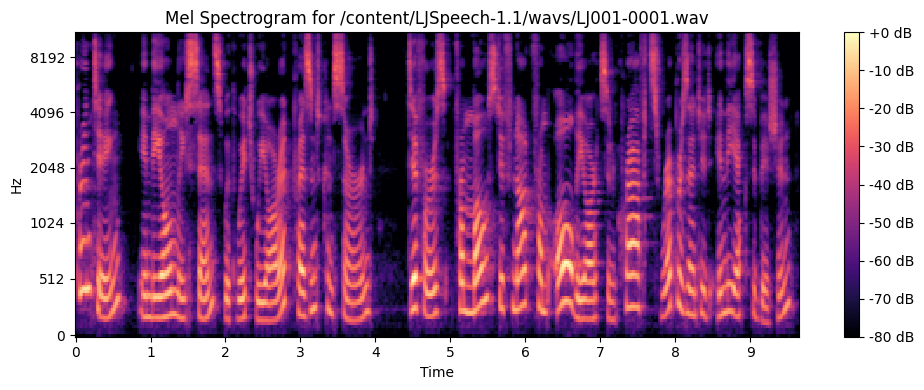

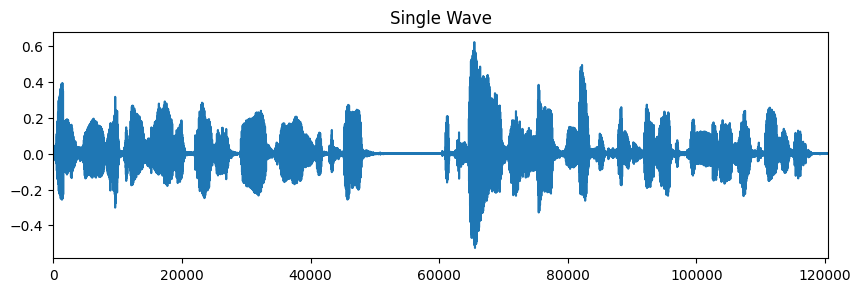

In [ ]:


def display_mel_spectrogram(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert to log scale (dB)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Display the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram for {}'.format(audio_path))
    plt.tight_layout()
    plt.show()

# Example usage (update the path to an actual audio file from your dataset)
audio_example_path = wavs_path + "LJ001-0001.wav"
display_mel_spectrogram(audio_example_path)



fig = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    label = batch[1][0]

    # Convert label numbers back to characters
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

    # # Plot spectrogram
    # ax = plt.subplot(3, 1, 1)
    # ax.imshow(spectrogram, vmax=1, aspect='auto')
    # ax.set_title(label)
    # ax.axis("off")

    # Read and plot the wav file
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(3, 1, 2)
    plt.plot(audio)
    ax.set_title("Single Wave")
    ax.set_xlim(0, len(audio))


plt.show()

In [ ]:
# Now I can give entire singal input to deep learning model and senetence as output

# And i can train that model

In [ ]:
def CTCLoss(y_true, y_pred):
    y_pred = tf.transpose(y_pred, perm=[1, 0, 2])
    return tf.keras.backend.ctc_loss(y_true, y_pred, tf.ones(tf.shape(y_true)[0]), tf.ones(tf.shape(y_pred)[0]))

In [ ]:
# Model


# We first define the CTC Loss fucntinos.

def CTCLoss(y_true, y_pred):
    # Compute the training-time of loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [ ]:
## We now Define our model. We will define a model similar to DeepSpeech2


def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNN layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

# Example usage

In [ ]:
# Get the Model

model = build_model(
    input_dim = fft_length // 2 + 1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units = 512,
)

model.summary(line_length=100)

Model: "DeepSpeech_2"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, None, 193)]                     0              
                                                                                                    
 expand_dim (Reshape)                        (None, None, 193, 1)                    0              
                                                                                                    
 conv_1 (Conv2D)                             (None, None, 97, 32)                    14432          
                                                                                                    
 conv_1_bn (BatchNormalization)              (None, None, 97, 32)                    128            
                                                                     